In [1]:
# load required libraries
options(stringsAsFactors = F)
options (warn = -1)
suppressPackageStartupMessages({
library(Seurat)
library(ggplot2)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
library(tidyr)
})
set.seed(123)

In [2]:
# load samples
sample <- CreateSeuratObject(Read10X_h5("matrix/filtered_feature_bc_matrix.h5"), project = "CAD1")
sample
head(sample@meta.data)

An object of class Seurat 
33538 features across 8595 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCAAGAAATTGC-1,CAD1,13261,4206
AAACCCAAGACCAAGC-1,CAD1,7448,3090
AAACCCAAGCGTGTTT-1,CAD1,9605,3798
AAACCCAGTCTAGATC-1,CAD1,6170,2630
AAACCCAGTGTTCCTC-1,CAD1,8703,3316
AAACCCAGTTAGGGTG-1,CAD1,11936,3619


In [3]:
# save the raw sample
saveRDS(sample, file = "./rds/CAD1_raw.rds")

In [4]:
# remove doublets
source("../scripts/dedoublet.R")
sample <- dedoublet(sample)
sample
saveRDS(sample, file = "./rds/CAD1_dedoublets.rds")

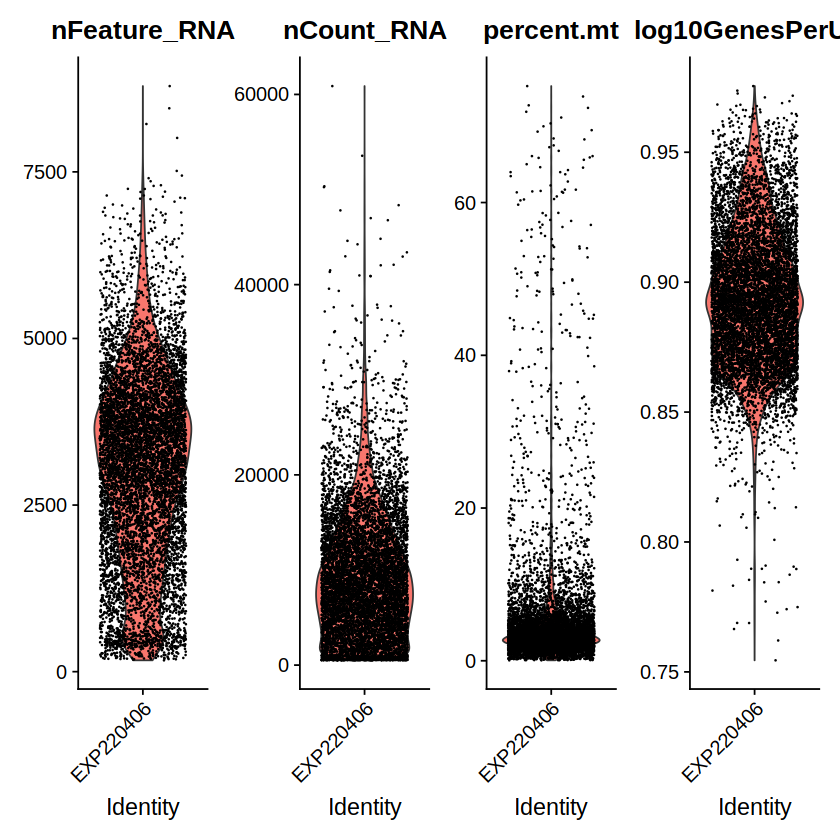

In [5]:
# count mitochondrial gene percentage and make plots
sample[["percent.mt"]] <- PercentageFeatureSet(sample, pattern = "^MT-")
sample$log10GenesPerUMI <- log10(sample$nFeature_RNA) / log10(sample$nCount_RNA)
VlnPlot(sample, features = c("nFeature_RNA", "nCount_RNA", "percent.mt", "log10GenesPerUMI"), ncol = 4, pt.size = 0.1)

In [6]:
# save the sample after nFeature_RNA & mito filtering
sample <- subset(sample, nFeature_RNA >= 500 & percent.mt <= 10)
saveRDS(sample, file = "rds/CAD1_clean.rds")

[1] 33538  7295

[1] 2000

Centering and scaling data matrix



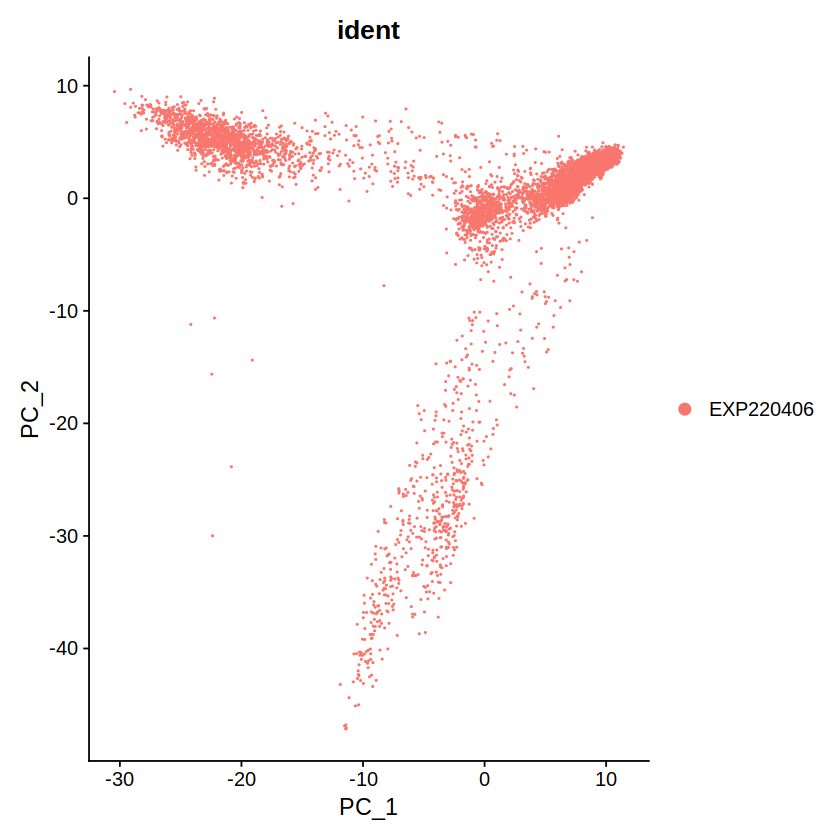

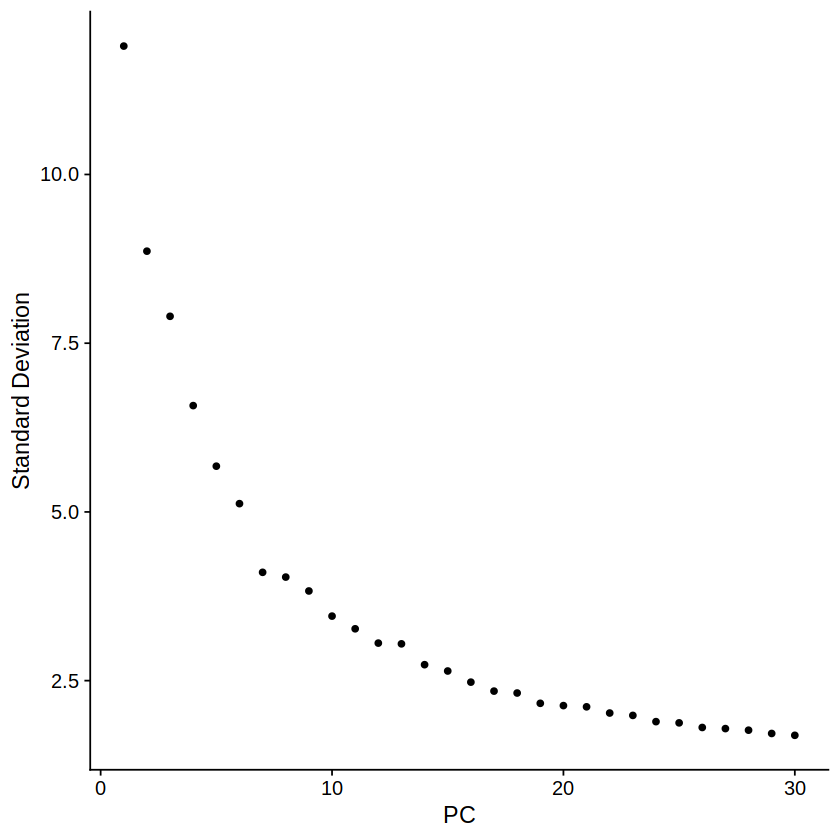

In [7]:
# filter cells and normalize data
sample <- NormalizeData(sample, normalization.method = "LogNormalize", scale.factor = 10000)
dim(GetAssayData(sample, slot = "counts"))

# find variable genes and scale data by number of UMIs and mitochondrial gene percentage
sample <- FindVariableFeatures(sample, selection.method = "vst")
length(sample@assays$RNA@var.features)
sample <- ScaleData(sample)

# run PCA and elbowplot
sample <- RunPCA(sample, verbose = FALSE)
DimPlot(sample, reduction = "pca", group.by = "ident")
ElbowPlot(sample, ndims = 30)

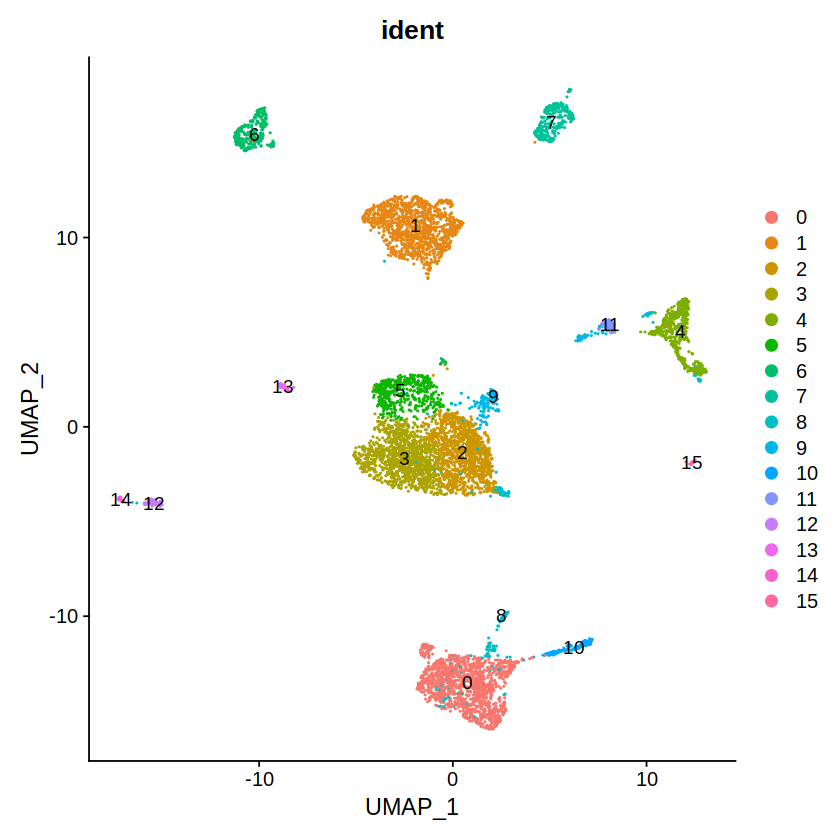

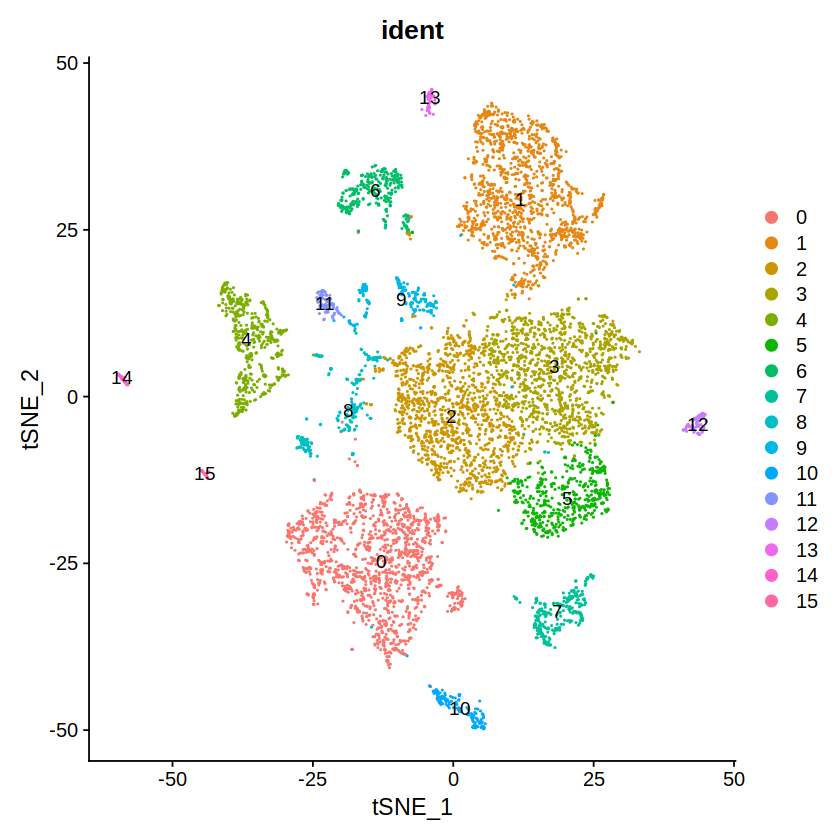

In [8]:
# dimension reduction
pca_dims <- 1:30
sample <- RunTSNE(sample, dims = pca_dims, verbose = FALSE)
sample <- RunUMAP(sample, dims = pca_dims, verbose = FALSE)
sample <- FindNeighbors(sample, dims = pca_dims, verbose = FALSE)
sample <- FindClusters(sample, resolution = 0.5, verbose = FALSE)

# make DM plots
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident")
DimPlot(sample, label = TRUE, reduction = "tsne", group.by = "ident")

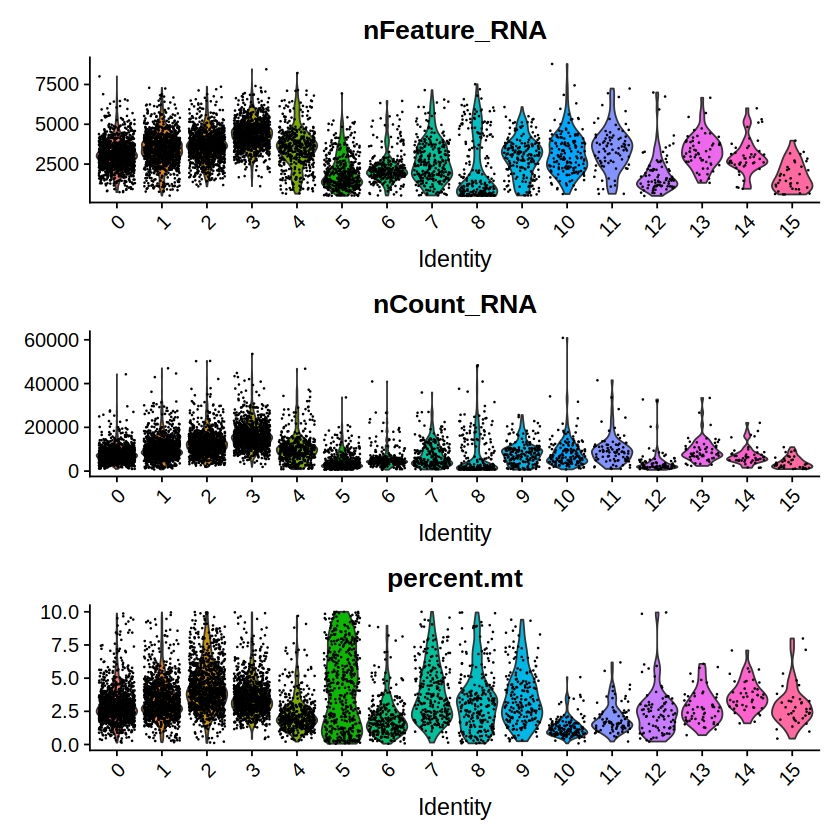

In [9]:
# quality control by cluster
VlnPlot(sample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 1, pt.size = 0.1)
ggsave("figure/qc_sample_by_cluster.pdf", width = 10, height = 10)

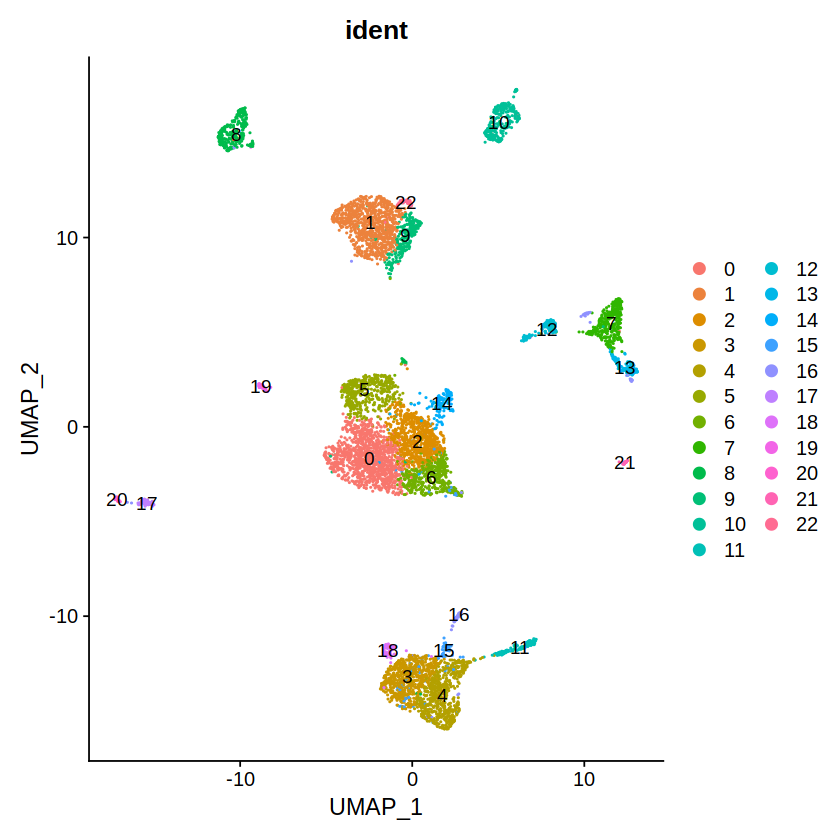

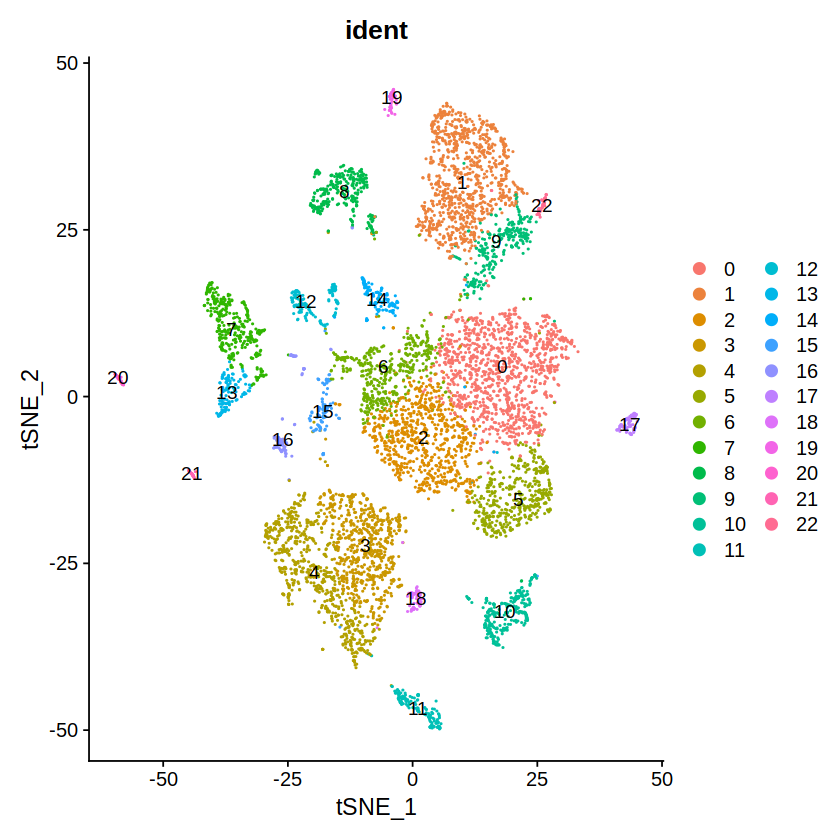

In [10]:
# add resolution
sample <- FindClusters(sample, resolution = 1, verbose = FALSE)
DimPlot(sample, label = TRUE, reduction = "umap", group.by = "ident")
DimPlot(sample, label = TRUE, reduction = "tsne", group.by = "ident")

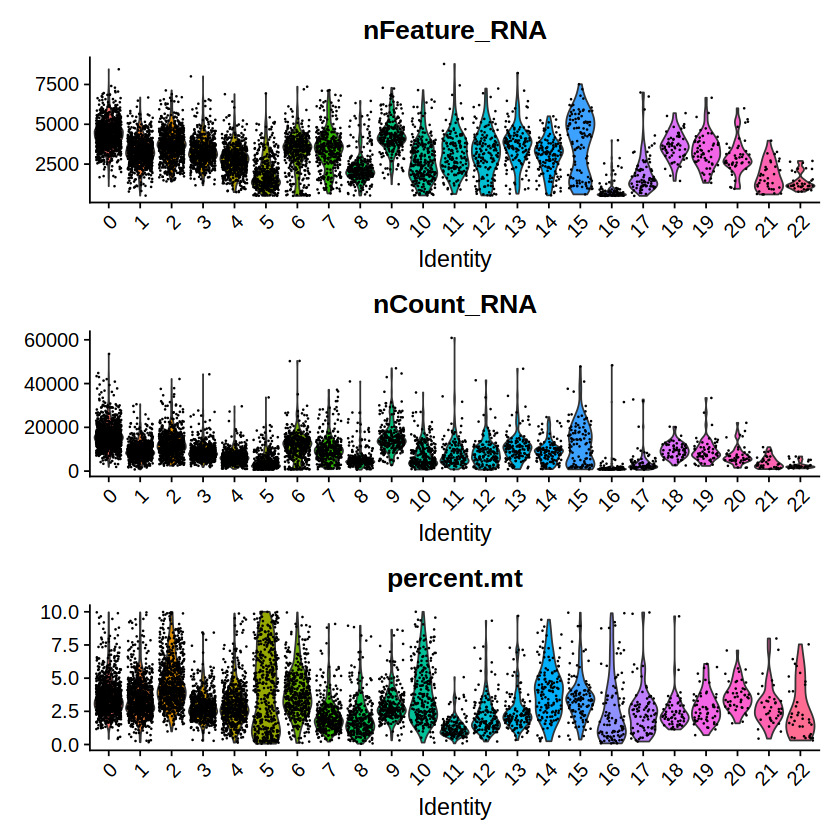

In [11]:
# quality control by cluster
VlnPlot(sample, features = c("nFeature_RNA","nCount_RNA","percent.mt"), group.by = "seurat_clusters", ncol = 1, pt.size = 0.1)
ggsave("figure/qc_sample_by_cluster_res1.pdf", width = 10, height = 10)

In [12]:
# save the clustered sample
saveRDS(sample, file = "rds/CAD1_clean_clustered.rds")

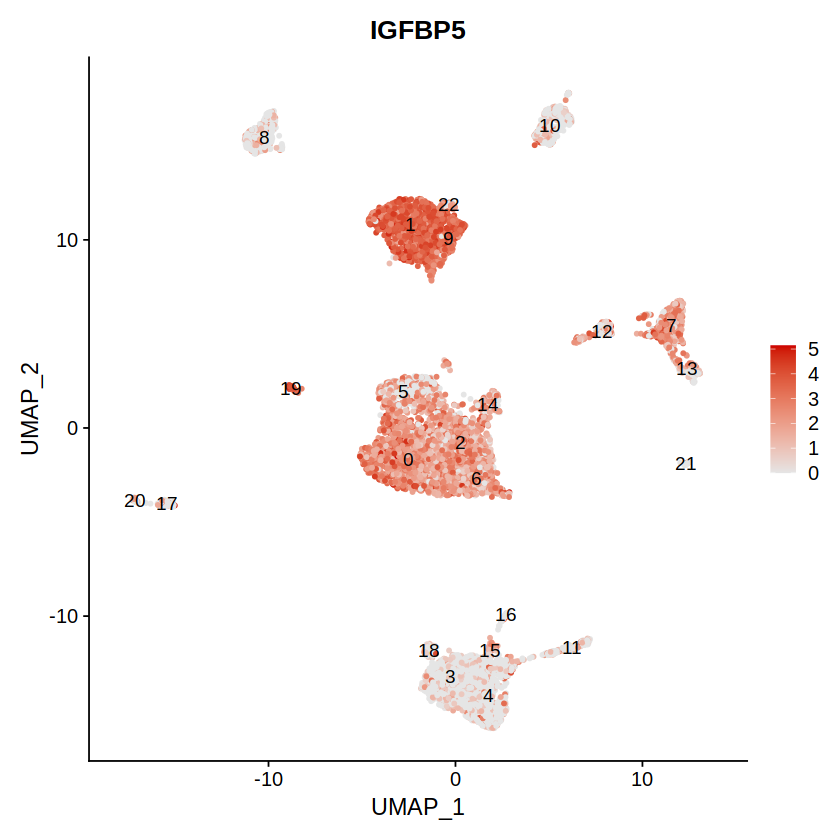

In [13]:
# explore marker genes
FeaturePlot(sample, label = T, features=c("IGFBP5"), cols=c("grey90","red3"), reduction="umap", pt.size = 1)

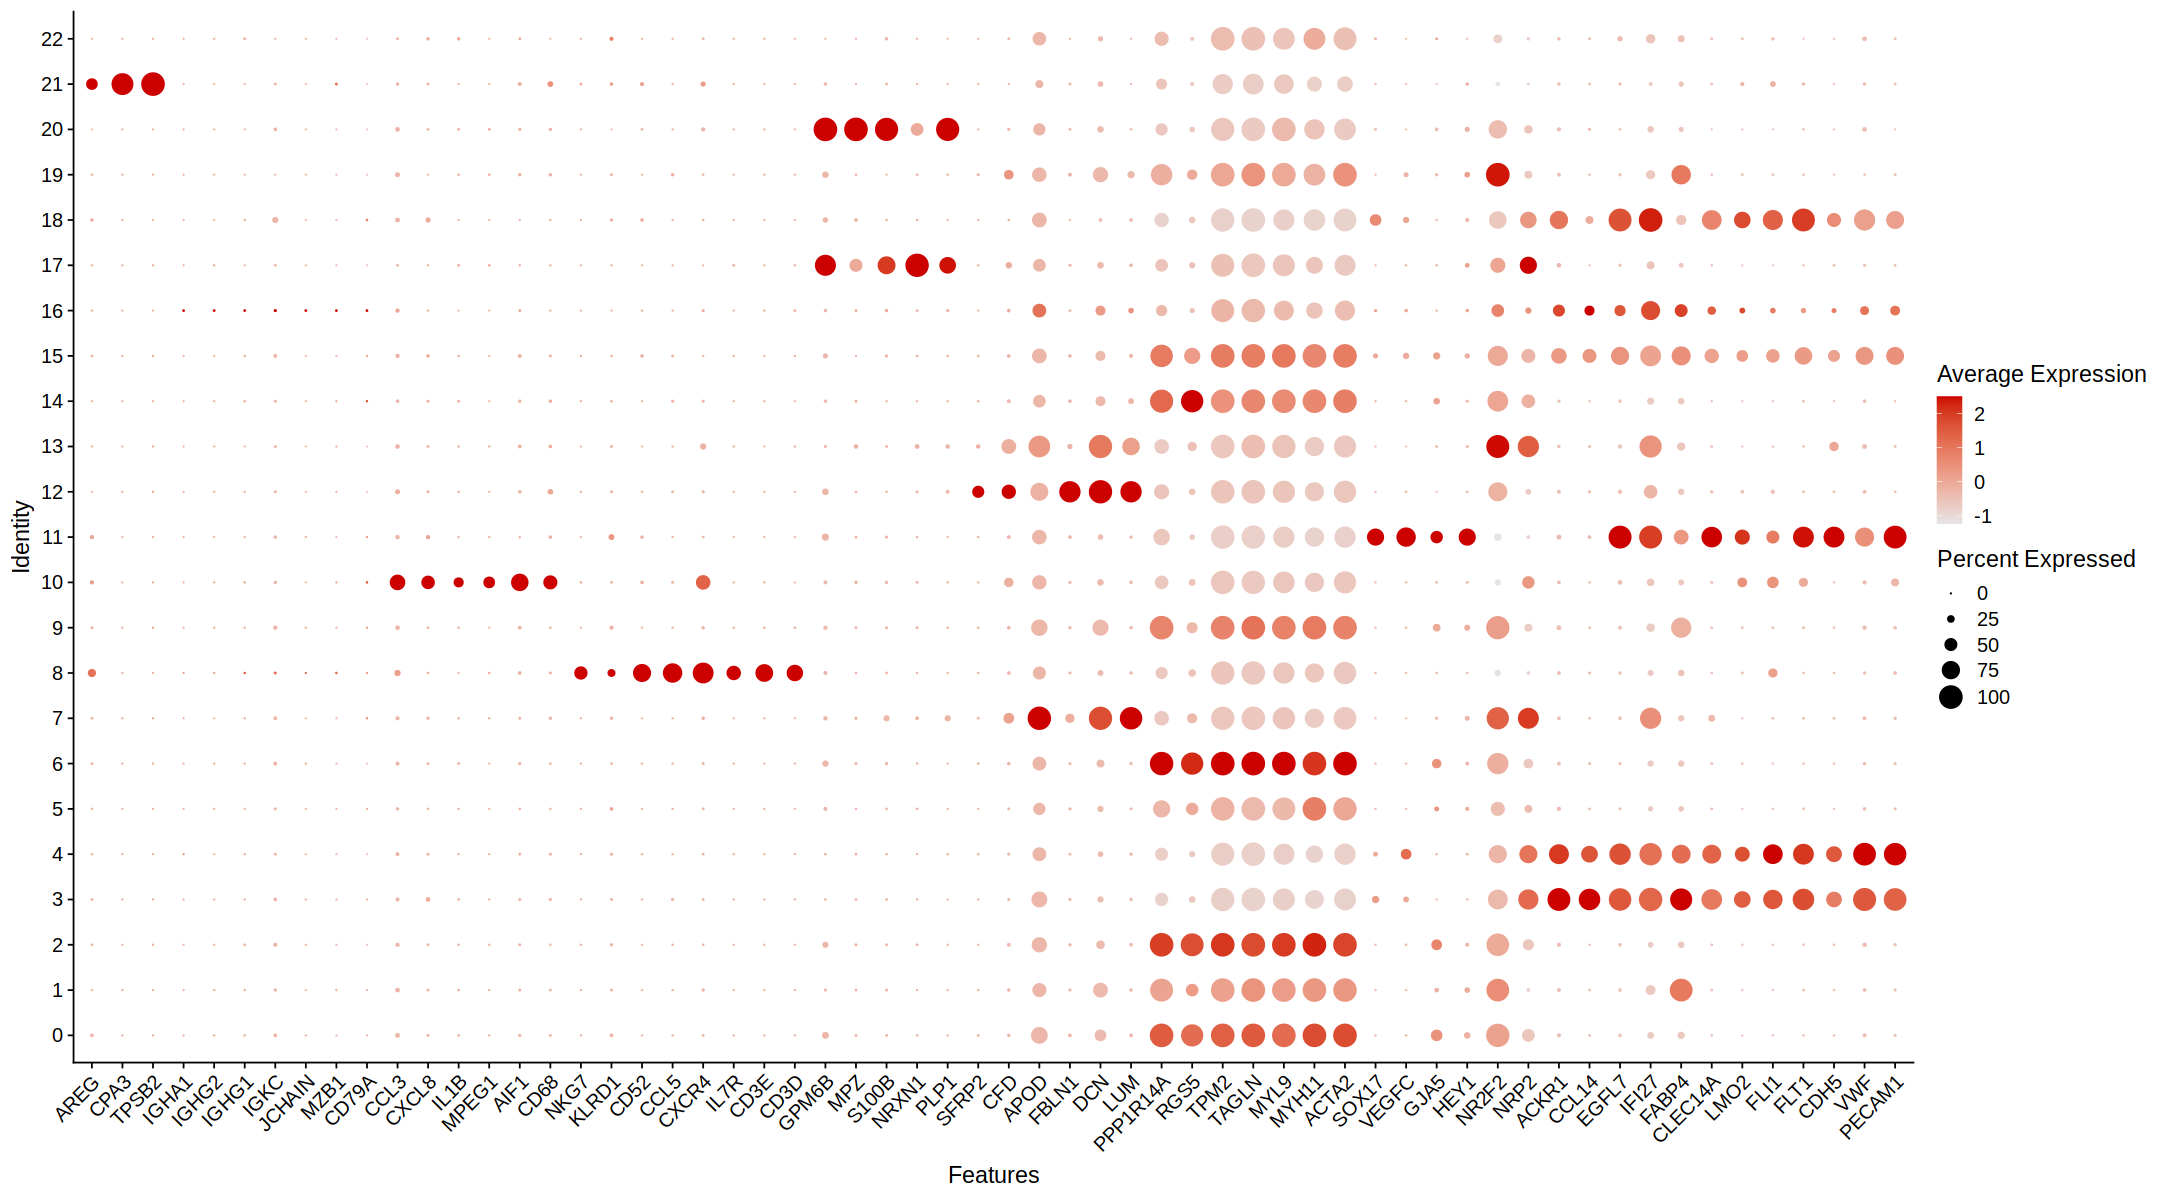

In [14]:
# plot marker genes list
options(repr.plot.width = 18, repr.plot.height = 10)
markers <- unique(c("PECAM1","VWF","CDH5","FLT1","FLI1","LMO2","CLEC14A","FABP4","IFI27","EGFL7", # EC
"CCL14","ACKR1","NRP2","NR2F2", # VEC
"HEY1","GJA5","VEGFC","SOX17", # AEC
"ACTA2","MYH11","MYL9","TAGLN","TPM2","RGS5","PPP1R14A", # SMC
"ACTA2","MYH11","LUM","DCN","PPP1R14A", # MyoFB
"LUM","DCN","FBLN1","APOD","CFD","SFRP2", # FB
"PLP1","NRXN1","S100B","MPZ","GPM6B", # OLG
"CD3D","CD3E","IL7R","CXCR4","CCL5","CD52", # T
"KLRD1","NKG7","CCL5", # NK
"CD68","AIF1","MPEG1","IL1B","CXCL8","CCL3","CXCR4", # Macrophage
"CD79A","MZB1","JCHAIN","IGKC","IGHG1","IGHG2","IGHA1", # B
"TPASB1","TPSB2","CPA3","AREG","HPGD5")) # Mast
DotPlot(sample, features=rev(markers), cols=c("grey90","red3"), group.by="seurat_clusters") + theme(axis.text.x=element_text(angle=45, hjust=1))
ggsave("figure/dotplot_CAD_markers.pdf", width = 18, height = 10)

In [15]:
# list the session info
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /data/zju/ty/miniconda/envs/singlecell/lib/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tidyr_1.3.1        ggrepel_0.9.4      RColorBrewer_1.1-3 Hmisc_5.1-1       
[5] Matrix_1.6-1.1     dplyr_1.1.4        ggplot2_3.5.1      SeuratObject_4.1.4
[9] Seurat_4.4.0      

loaded via a namespace (and not attache